In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#|default_exp trimesh_to_gaussians

In [3]:
#|export
_doc_ = """
# Trimesh to Gaussians
> Pretty much self-explanatory

**Example:**
```python
from bayes3d._mkl.trimesh_to_gaussians import (
    patch_trimesh, 
    uniformly_sample_from_mesh, 
    ellipsoid_embedding, 
    get_mean_colors, 
    pack_transform,
    transform_from_gaussian
)
import trimesh
import numpy as np
import jax.numpy as jnp
import jax
from jax import jit, vmap
from sklearn.mixture import GaussianMixture
from bayes3d._mkl.utils import keysplit

# SEED
key = jax.random.PRNGKey(0)

# LOAD MESH
# -------------------
mesh = load_mesh(...)
mesh = patch_trimesh(mesh)

# SAMPLE FROM MESH
# ----------------
key = keysplit(key)
n = 20_000
xs, cs = uniformly_sample_from_mesh(key, n, mesh, with_color=True)

# GMM CONFIG
# ----------
key = keysplit(key)
n_components = 150
noise        = 0.0; 
X            = xs + np.random.randn(*xs.shape)*noise
means_init   = np.array(uniformly_sample_from_mesh(key, n_components, mesh, with_color=False)[0]);

# FIT THE GMM
# -----------
gm = GaussianMixture(n_components=n_components, 
                     tol=1e-3, max_iter=100, 
                     covariance_type="full", 
                     means_init=means_init).fit(X)

mus        = gm.means_
covs       = gm.covariances_
labels     = gm.predict(X)
choleskys  = vmap(ellipsoid_embedding)(covs)
transforms = vmap(transform_from_gaussian, (0,0,None))(mus, covs, 2.0)
mean_colors, nums = get_mean_colors(cs, gm.n_components, labels)
```
"""

In [4]:
#|export
import bayes3d as b3d
import trimesh
from bayes3d._mkl.utils import *
import os
import matplotlib.pyplot as plt
import numpy as np
import jax
from jax import jit, vmap
import jax.numpy as jnp
from typing import Any, NamedTuple
import jaxlib

Array = np.ndarray | jax.Array
Shape = int | tuple[int, ...]
FaceIndex = int
FaceIndices = Array
Array3      = Array
Array2      = Array
ArrayNx2    = Array
ArrayNx3    = Array
Matrix      = jaxlib.xla_extension.ArrayImpl
PrecisionMatrix  = Matrix
CovarianceMatrix = Matrix
SquareMatrix     = Matrix
Vector = Array

In [5]:
key = jax.random.PRNGKey(0)

In [6]:
#|export
def area_of_triangle(a:Array3, b:Array3, c:Array3=jnp.zeros(3)):
    """Computes the area of a triangle spanned by a,b[,c]."""
    x = a-c
    y = b-c
    w = jnp.linalg.norm(x)
    h = jnp.linalg.norm(y - jnp.dot(x, y)/w**2 * x)
    area = w*h/2

    return area


def _compute_area_and_normal(f, vertices):
    a = vertices[f[1]] - vertices[f[0]]
    b = vertices[f[2]] - vertices[f[0]]
    area = area_of_triangle(a, b)
    normal = jnp.cross(a,b)
    return area, normal


compute_area_and_normals = jit(vmap(_compute_area_and_normal, (0,None)))

In [7]:
#|export
def patch_trimesh(mesh:trimesh.base.Trimesh):
    """
    Return a patched copy of a trimesh object, and 
    ensure it to have a texture and the following attributes:
     - `mesh.visual.uv`
     - `copy.visual.material.to_color`
    """
    patched_mesh = mesh.copy()
    if isinstance(mesh.visual, trimesh.visual.color.ColorVisuals):
        patched_mesh.visual = mesh.visual.to_texture()
    elif isinstance(mesh.visual, trimesh.visual.texture.TextureVisuals):
        pass

    return patched_mesh


def texture_uv_basis(face_idx:Array, mesh):
    """
    Takes a face index and returns the three uv-vectors 
    spanning the face in texture space.
    """
    return mesh.visual.uv[mesh.faces[face_idx]]


def uv_to_color(uv:ArrayNx2, mesh):
    """Takes texture-uv coordinates and returns the corresponding color."""
    return mesh.visual.material.to_color(uv)

In [8]:
#|export
def barycentric_to_mesh(p:Array3, i:FaceIndex, mesh):
    """Converts a point in barycentric coordinates `p` on a face `i` to a 3d point on the mesh."""
    x = jnp.sum(p[:,None]*mesh.vertices[mesh.faces[i]], axis=0)
    return x


def sample_from_face(key, n, i, mesh):
    """
    Sample random points `xs`, barycentric coordinates `ps`, and 
    face indices `fs` from a mesh.
    """
    _, key = keysplit(key,1,1)
    ps = jax.random.dirichlet(key, jnp.ones(3), (n,)).reshape((n,3,1))
    xs = jnp.sum(ps*mesh.vertices[mesh.faces[i]], axis=1)
    return xs, ps


def sample_from_mesh(key, n, mesh):
    """
    Returns random points `xs`, barycentric coordinates `ps`, and 
    face indices `fs` from a mesh.
    """
    _, keys = keysplit(key,1,2)

    # Sample `n` faces from the mesh with 
    # probability proportional to their area. 
    areas, _ = compute_area_and_normals(mesh.faces, mesh.vertices)
    fs = jax.random.categorical(keys[0], jnp.log(areas), shape=(n,))

    # Sample barycentric coordinates `bs` for each sampled face
    # and compute the corresponding world coordinates `xs`.
    ps = jax.random.dirichlet(keys[1], jnp.ones(3), (n,)).reshape((n,3,1))
    xs = jnp.sum(ps*mesh.vertices[mesh.faces[fs]], axis=1)
    return xs, ps, fs
    

def get_colors_from_mesh(ps:ArrayNx3, fs:FaceIndices, mesh):
    """
    Returns the colors of the points on the mesh given 
    their barycentric coordinates `ps` and face indices `fs`.
    """
    uvs = jnp.sum(ps * texture_uv_basis(fs, mesh), axis=1)
    cs  = uv_to_color(uvs, mesh)/255
    return cs

In [9]:
help(sample_from_mesh)

Help on function sample_from_mesh in module __main__:

sample_from_mesh(key, n, mesh)
    Returns random points `xs`, barycentric coordinates `ps`, and 
    face indices `fs` from a mesh.



In [10]:
#|export
def uniformly_sample_from_mesh(key, n, mesh, with_color=True):
    """Uniformly sample `n` points and optionally their color on the surface from a mesh."""
    xs, ps, fs = sample_from_mesh(key, n, mesh)

    if with_color:
        cs = get_colors_from_mesh(ps, fs, mesh)
    else:
        cs = jnp.full((n,3), 0.5)

    return xs, cs

In [11]:
#|export
def get_cluster_counts(m, labels):
    nums = []
    for label in range(m):
        nums.append(np.sum(labels == label))
    return np.array(nums)


#|export
def get_cluster_colors(cs, m, labels):
    colors = []
    for label in range(m):
        colors.append(cs[labels == label])
    return colors

In [12]:
#|export
def get_mean_colors(cs, n, labels):
    mean_colors = []
    nums        = []
    for label in range(n):
        idx = labels == label
        num = np.sum(idx)
        if num == 0: 
            c = np.array([0.5, 0.5, 0.5, 0.0])
        else: 
            c = np.mean(cs[idx], axis=0)
        nums.append(num)
        mean_colors.append(c)

    return np.array(mean_colors), np.array(nums)
    

In [13]:
#|export
def ellipsoid_embedding(cov:CovarianceMatrix) -> Matrix:
    """Returns A with cov = A@A.T"""
    sigma, U = jnp.linalg.eigh(cov)
    D = jnp.diag(jnp.sqrt(sigma))
    return U @ D @ jnp.linalg.inv(U)


In [14]:
#|export
def pack_transform(x, A, scale=1.0):
    B = scale*A
    return jnp.array([
        [B[0,0], B[0,1], B[0,2], x[0]], 
        [B[1,0], B[1,1], B[1,2], x[1]],
        [B[2,0], B[2,1], B[2,2], x[2]],
        [0.0, 0.0, 0.0, 1.0]
    ]).T


def transform_from_gaussian(mu:Vector, cov:CovarianceMatrix=jnp.eye(3), scale=1.0) -> Matrix:
    """Returns an affine linear transformation 4x4 matrix from a Gaussian."""
    A = ellipsoid_embedding(cov)
    B = scale * A
    return jnp.array([
        [B[0,0], B[0,1], B[0,2], mu[0]], 
        [B[1,0], B[1,1], B[1,2], mu[1]],
        [B[2,0], B[2,1], B[2,2], mu[2]],
        [0.0, 0.0, 0.0, 1.0]
    ]).T

In [15]:
#|export
def create_ellipsoid_trimesh(covariance_matrix, num_points=10, scale=0.02):
    # Create a sphere
    u = np.linspace(0, 2 * np.pi, num_points)
    v = np.linspace(0, np.pi, num_points)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    # Transform the sphere to the ellipsoid
    sigma, U = np.linalg.eig(covariance_matrix)
    D = np.diag(np.sqrt(sigma))
    ellipsoid = U @ D @ np.linalg.inv(U) @ np.vstack([x.flatten(), y.flatten(), z.flatten()])

    # Reshape the ellipsoid to match the shape of the original sphere vertices
    ellipsoid = ellipsoid.T.reshape(num_points, num_points, 3)

    # Create mesh data
    mesh_vertices = scale*ellipsoid.reshape(-1, 3)
    mesh_faces = []
    for i in range(num_points - 1):
        for j in range(num_points - 1):
            v1 = i * num_points + j
            v2 = v1 + 1
            v3 = (i + 1) * num_points + j
            v4 = v3 + 1
            mesh_faces.append([v1, v2, v3])
            mesh_faces.append([v2, v4, v3])

    mesh_faces = np.array(mesh_faces)

    # Create a trimesh object
    trimesh_mesh = trimesh.Trimesh(vertices=mesh_vertices, faces=mesh_faces)

    return trimesh_mesh

## Load Mesh

Source for all sorts of 3d meshes:
- https://sketchfab.com/3d-models/walking-astronaut-896d68114e70422d8a2ebc1be6eed4a7
- https://sketchfab.com/3d-models/eyeball-kid-d99d9181b1fe40fe993dadfa2c0fd691
- https://sketchfab.com/search?features=animated&q=tree&type=models
- https://sketchfab.com/3d-models/rigged-animated-cinematic-quality-tree-4-544329bb254d4e45b5eae96ccc5bacf6

In [17]:
t=0
fname = f"data/flag_objs/flag_t_{t}.obj"
mesh  = trimesh.load(fname)
mesh = patch_trimesh(mesh)

In [16]:
idx = 10 # banana 10, scissors 17


_scaling  = 1e-3
model_dir = os.path.join(b3d.utils.get_assets_dir(),"bop/ycbv/models")
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
mesh = trimesh.load(mesh_path)
mesh.vertices *= _scaling 


mesh = patch_trimesh(mesh)

In [17]:
(
    mesh.metadata["file_path"],
    mesh.metadata["file_name"],
)

('/home/mirko/workspace/bayes3d/assets/bop/ycbv/models/obj_000010.ply',
 'obj_000010.ply')

## Fit GMM

In [18]:
mesh = patch_trimesh(mesh)

print(f"""
    mesh.vertices: {mesh.vertices.shape}
    mesh.faces   : {mesh.faces.shape}
    mesh.uv      : {mesh.visual.uv.shape}
""")


    mesh.vertices: (10710, 3)
    mesh.faces   : (15728, 3)
    mesh.uv      : (10710, 2)



In [22]:
from sklearn.mixture import GaussianMixture


# Patch mesh
# ----------
mesh = patch_trimesh(mesh)


# Sample from mesh
# ----------------
key = keysplit(key)
n = 10_00
xs, cs = uniformly_sample_from_mesh(key, n, mesh, with_color=True)


# GMM config
# ----------
key = keysplit(key)
n_components = 100
noise        = 0.0; 
X            = xs + np.random.randn(*xs.shape)*noise
means_init   = np.array(uniformly_sample_from_mesh(key, n_components, mesh, with_color=False)[0]);


# Fit the GMM
# -----------
gm = GaussianMixture(n_components=n_components, 
                     tol=1e-3, max_iter=100, 
                     covariance_type="full", 
                     means_init=means_init).fit(X)


mus        = gm.means_
covs       = gm.covariances_
labels     = gm.predict(X)
choleskys  = vmap(ellipsoid_embedding)(covs)
transforms = vmap(pack_transform, (0,0,None))(mus, choleskys, 2.0)
mean_colors, nums = get_mean_colors(cs, gm.n_components, labels)
valid = nums > 0

2023-11-29 11:05:40.029194: W external/xla/xla/service/gpu/runtime/support.cc:58] Intercepted XLA runtime error:
INTERNAL: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error
2023-11-29 11:05:40.029262: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2716] Execution of replica 0 failed: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error; current tracing scope: custom-call.13; current profiling annotation: XlaModule:#hlo_module=jit_eigh,program_id=39#.


XlaRuntimeError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error; current tracing scope: custom-call.13; current profiling annotation: XlaModule:#hlo_module=jit_eigh,program_id=39#.

In [42]:
fname = f"data/gaussians_{n_components}.npz"
jnp.savez(fname, mus=mus[valid], covs=covs[valid], colors=mean_colors[valid], choleskys=choleskys[valid])
fname

'data/gaussians_100.npz'

## Visualize

In [115]:
import traceviz.client
import numpy as np
from traceviz.proto import  viz_pb2
import json


In [117]:
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "setup"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg([]))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "gaussians"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg({
        'transforms': np.array(transforms )[nums>0], 
        'colors':     np.array(mean_colors)[nums>0]  
}))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


response:  listener_identifiers: "2023-11-24T16:34:56.251992 :: ipv4:127.0.0.1:42676"

response:  listener_identifiers: "2023-11-24T16:34:56.251992 :: ipv4:127.0.0.1:42676"



## Save

In [ ]:
jnp.savez(f"data/gaussians_scissors_{mus.shape[0]}.npz", mus=mus, covs=covs, choleskys=choleskys, mean_colors=mean_colors, nums=nums)

In [168]:
key = keysplit(key)

n = 10_000
xs, cs = uniformly_sample_from_mesh(key, n, mesh, with_color=True)
covs = jnp.tile(jnp.eye(3), (n,1,1))

# jnp.savez(f"data/gaussians_test.npz", mus=xs, covs=covs, colors=cs)

In [170]:
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "setup"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg([]))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "spheres"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg({
        'centers': np.array(xs), 
        'colors':  np.array(cs),
        'scales':  np.ones(n)*0.01,
}))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))

response:  listener_identifiers: "2023-11-24T16:43:08.164712 :: ipv4:127.0.0.1:56284"

response:  listener_identifiers: "2023-11-24T16:43:08.164712 :: ipv4:127.0.0.1:56284"



In [64]:
Xs = []
Cs = []
for t in range(10):
    n = 10_000
    key = keysplit(key)
    xs, cs = uniformly_sample_from_mesh(key, n, mesh, with_color=True)
    Xs.append(xs)
    Cs.append(cs)

Xs = np.array(Xs)
Cs = np.array(Cs)

Xs.shape, Cs.shape

((10, 10000, 3), (10, 10000, 4))

In [65]:
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "setup"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg([]))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "animated spheres"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg({
        'centers': np.array(Xs), 
        'colors':  np.array(Cs),
        'scales':  np.ones((len(Xs),n))*0.004,
}))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))

response:  listener_identifiers: "2023-11-24T13:36:43.417848 :: ipv4:127.0.0.1:58790"

response:  listener_identifiers: "2023-11-24T13:36:43.417848 :: ipv4:127.0.0.1:58790"



In [32]:
transforms = vmap(transform_from_gaussian, (0,0,None))(xs, covs, .02)


msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "setup"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg([]))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "Gaussians2"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg({
        'transforms': np.array(transforms ), 
        'colors':     np.array(cs)
}))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


response:  listener_identifiers: "2023-11-22T12:12:24.738319 :: ipv4:127.0.0.1:48720"

response:  listener_identifiers: "2023-11-22T12:12:24.738319 :: ipv4:127.0.0.1:48720"



## Appendix

In [232]:
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "setup"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg([]))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


response:  listener_identifiers: "2023-11-15T14:39:07.745000 :: ipv4:127.0.0.1:48652"



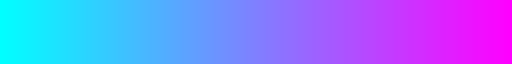

In [233]:


cm  = getattr(plt.cm, "cool")
# cs  = cm(plt.Normalize()(vs_))
cm

In [171]:
key = keysplit(key)
xs_, cs_, _ = uniformly_sample_from_mesh(key, 15_000, mesh.faces, mesh.vertices, 
                texture_uv=texvis.uv, uv_to_color=texvis.material.to_color)

# labels_ = gm.predict(xs_)
# cols_ = mean_colors[labels_]
# cs_.shape, cols_.shape



# distances = np.linalg.norm(cs_ - cols_, axis=1)
# print(distances.shape)
# print(np.min(distances), np.max(distances))
# cs_  = cm(plt.Normalize()(distances))
# cs_.shape

NameError: name 'texvis' is not defined

In [148]:


print(xs_.shape, cs_.shape)


msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "Spheres"})
msg.payload.data.MergeFrom(
    traceviz.client.to_pytree_msg({
        'centers': np.array(xs_), 
        'colors': np.array(cs_), 
        "scales": 0.025*np.ones(len(xs_))
    })
)
    

stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


NameError: name 'xs_' is not defined